In [1]:
%matplotlib inline
from collections import defaultdict
import csv
import os
import sys

import matplotlib.pyplot
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
import time
import pandas as pd
from skimage.transform import resize
np.random.seed(42)

csv.field_size_limit(sys.maxsize);
cur_dir = '/home/rob/Udacity/capstone/data'

print cv2.__version__

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle

3.2.0-dev


In [15]:
ClassNames = {'1':'buildings', '2':'Misc. Manmade structures', '3': 'Road', '4':'Track', '5':'Trees',
                    '6':'Crops', '7':'Waterway', '8':'Standing water', '9':'Vehicle Large ', '10':'Vehicle Small'}

save_masks = False


def get_scalers(im_size):
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

def mask_for_polygons(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

def show_mask(m):
        
    tiff.imshow(255 * np.stack([m, m, m]));
    
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        try:
            all_polygons = all_polygons.buffer(0)
        except ValueError:
            print "standard buffer not possible. Use -1"
            try:
                all_polygons = all_polygons.buffer(0)
            except ValueError:
                print "-1 buffer not possible. Use -2"
                all_polygons = all_polygons.buffer(-2)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons


In [4]:
classifiers = {}
train_masks = {}
pred_masks = {}

trainIM_IDs = []
with open(cur_dir + '/train_wkt_v4.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar=',')
    for i,row in enumerate(reader):
        if i == 0:
            i = 1
        if (i%10) == 0:
            trainIM_IDs.append(row[0])
            
testIM_IDs = []
with open(cur_dir + '/sample_submission.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar=',')
    for i,row in enumerate(reader):
        if i == 0:
            i = 1
        if (i%10) == 0:
            testIM_IDs.append(row[0])

In [8]:
#Needed to be done only once. Parameters collected from this come below

all_pictures = trainIM_IDs + testIM_IDs
scaler = StandardScaler()
counter = 0
nrOfPics = len(all_pictures)
for IM_ID in all_pictures:
    counter += 1
    print "Image {} of {}".format(counter, nrOfPics)
    im_rgb = tiff.imread(cur_dir +'/sixteen_band/{}_M.tif'.format(IM_ID)).transpose([1, 2, 0]) #gives back lists of lists
    xs = im_rgb.reshape(-1, 8).astype(np.float32) #reshape(-1, 3)

    scaler.partial_fit(xs)



Image 1 of 454
Image 2 of 454
Image 3 of 454
Image 4 of 454
Image 5 of 454
Image 6 of 454
Image 7 of 454
Image 8 of 454
Image 9 of 454
Image 10 of 454
Image 11 of 454
Image 12 of 454
Image 13 of 454
Image 14 of 454
Image 15 of 454
Image 16 of 454
Image 17 of 454
Image 18 of 454
Image 19 of 454
Image 20 of 454
Image 21 of 454
Image 22 of 454
Image 23 of 454
Image 24 of 454
Image 25 of 454
Image 26 of 454
Image 27 of 454
Image 28 of 454
Image 29 of 454
Image 30 of 454
Image 31 of 454
Image 32 of 454
Image 33 of 454
Image 34 of 454
Image 35 of 454
Image 36 of 454
Image 37 of 454
Image 38 of 454
Image 39 of 454
Image 40 of 454
Image 41 of 454
Image 42 of 454
Image 43 of 454
Image 44 of 454
Image 45 of 454
Image 46 of 454
Image 47 of 454
Image 48 of 454
Image 49 of 454
Image 50 of 454
Image 51 of 454
Image 52 of 454
Image 53 of 454
Image 54 of 454
Image 55 of 454
Image 56 of 454
Image 57 of 454
Image 58 of 454
Image 59 of 454
Image 60 of 454
Image 61 of 454
Image 62 of 454
Image 63 of 454
I

In [5]:
'''
mean = np.array([433.34481531,  470.12561474,  336.34651428])
std = np.array([ 47605.91705942,  29675.8796264,   11835.19386262])
scale = np.array([ 218.18780227,  172.26688488,  108.78967719])
scaler = StandardScaler()
scaler.mean_ = mean
scaler.var_ = std
scaler.scale_ = scale'''

In [6]:
#This is a suitable building block to build a learner that learns all 10 classes at once
'''
counter = 1
train_set = trainIM_IDs[1:] + [trainIM_IDs[0]]
timer = time.time()
percentiles = range(1,21)
concatTrainSamples = []
concatTrainLabels = []

for percentile in percentiles:
    percentile = float(percentile)/(len(percentiles))
    

    for IM_ID in train_set:
        print IM_ID
        print "{}. picture of {}".format(counter, trainDataLength)

        x_max = y_min = None
        for _im_id, _x, _y in csv.reader(open(cur_dir + '/grid_sizes.csv')):
            if _im_id == IM_ID:
                x_max, y_min = float(_x), float(_y)
                break


        for i in range(1,11): #range(1,11)
            POLY_TYPE = str(i)
            print ClassNames[POLY_TYPE]
            l1.append(IM_ID)
            l2.append(ClassNames[POLY_TYPE])

            # Load train poly with shapely
            train_polygons = None
            for _im_id, _poly_type, _poly in csv.reader(open(cur_dir + '/train_wkt_v4.csv')):
                if _im_id == IM_ID and _poly_type == POLY_TYPE:
                    train_polygons = shapely.wkt.loads(_poly)
                    break

            im_rgb = tiff.imread(cur_dir +'/three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
            im_size = im_rgb.shape[:2]
            x_scaler, y_scaler = get_scalers(im_size)

            train_polygons_scaled = shapely.affinity.scale(
                train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

            train_mask = mask_for_polygons(train_polygons_scaled)

            xs = (im_rgb.reshape(-1, 3).astype(np.float32))
            ys = train_mask.reshape(-1)
            xs = scaler.transform(xs)

            """
            Now only concatenate. Learning happens in the outermost loop.
            """
            concatTrainSamples += xs[int(len(xs)*(percentile- 1./len(percentiles))):int(len(xs)*(percentile)]
            concatTrainLabels += ys[int(len(xs)*(percentile- 1./len(percentiles))):int(len(xs)*(percentile)]
                                                                                       
'''    

'\ncounter = 1\ntrain_set = trainIM_IDs[1:] + [trainIM_IDs[0]]\ntimer = time.time()\npercentiles = range(1,21)\nconcatTrainSamples = []\nconcatTrainLabels = []\n\nfor percentile in percentiles:\n    percentile = float(percentile)/(len(percentiles))\n    \n\n    for IM_ID in train_set:\n        print IM_ID\n        print "{}. picture of {}".format(counter, trainDataLength)\n\n        x_max = y_min = None\n        for _im_id, _x, _y in csv.reader(open(cur_dir + \'/grid_sizes.csv\')):\n            if _im_id == IM_ID:\n                x_max, y_min = float(_x), float(_y)\n                break\n\n\n        for i in range(1,11): #range(1,11)\n            POLY_TYPE = str(i)\n            print ClassNames[POLY_TYPE]\n            l1.append(IM_ID)\n            l2.append(ClassNames[POLY_TYPE])\n\n            # Load train poly with shapely\n            train_polygons = None\n            for _im_id, _poly_type, _poly in csv.reader(open(cur_dir + \'/train_wkt_v4.csv\')):\n                if _im_id ==

In [19]:
counter = 1
train_set = trainIM_IDs[1:] + [trainIM_IDs[0]]
timer = time.time()
percentiles = range(1,21)

epsilon=5.
min_area=5.

min_areas = {'1':10.,'2':2.,'3':10.,'4':10.,'5':2.,'6':12.,'7':8.,'8':14.,'9':1.,'10':1.}

for i in range(1,11): #range(1,11)
    POLY_TYPE = str(i)
    print ClassNames[POLY_TYPE]

    for percentile in percentiles:
        percentile = float(percentile)/(len(percentiles))
        print "Percentile: {}".format(percentile)
        counter = 1
        
        concatTrainSamples = None
        concatTrainLabels = None
        
        for IM_ID in train_set:
            print IM_ID
            print "{}. picture of {}".format(counter, '25')

            x_max = y_min = None
            for _im_id, _x, _y in csv.reader(open(cur_dir + '/grid_sizes.csv')):
                if _im_id == IM_ID:
                    x_max, y_min = float(_x), float(_y)
                    break





            # Load train poly with shapely
            train_polygons = None
            for _im_id, _poly_type, _poly in csv.reader(open(cur_dir + '/train_wkt_v4.csv')):
                if _im_id == IM_ID and _poly_type == POLY_TYPE:
                    train_polygons = shapely.wkt.loads(_poly)
                    break

            im_rgb = tiff.imread(cur_dir +'/sixteen_band/{}_M.tif'.format(IM_ID)).transpose([1, 2, 0])
            im_size = im_rgb.shape[:2]
            
            
            x_scaler, y_scaler = get_scalers(im_size)

            train_polygons_scaled = shapely.affinity.scale(
                train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

            train_mask = mask_for_polygons(train_polygons_scaled)

            xs = (im_rgb.reshape(-1, 8).astype(np.float32))
            ys = train_mask.reshape(-1)
            xs = scaler.transform(xs)

            """
            Now only concatenate. Learning happens in the Image_ID loop.
            """

            try:
                concatTrainSamples = np.concatenate((xs[int(len(xs)*(percentile- 1./len(percentiles))):
                                                       int(len(xs)*(percentile))] , concatTrainSamples), axis=0)
                concatTrainLabels = np.concatenate((ys[int(len(xs)*(percentile- 1./len(percentiles))):
                                                      int(len(xs)*(percentile))] , concatTrainLabels), axis=0)
            except:
                print "except statement entered: First call for this percentile!"
                concatTrainSamples = xs[int(len(xs)*(percentile- 1./len(percentiles))):int(len(xs)*(percentile))]
                concatTrainLabels = ys[int(len(xs)*(percentile- 1./len(percentiles))):int(len(xs)*(percentile))]

            counter += 1
            
        try:
            print "Using saved classifier"
            clf = classifiers["SGD{}".format(ClassNames[POLY_TYPE])]
        except:
            print "Classifier initialized for this Class"
            clf = SGDClassifier(loss='log',n_iter=2)
        print('training...')
        shuffle(concatTrainSamples, concatTrainLabels, random_state=0)
        
        try:
            clf = clf.partial_fit(concatTrainSamples,concatTrainLabels, [0,1])
            
        except ValueError:
            "Class not represented"
            classifiers["SGD{}".format(ClassNames[POLY_TYPE])] = clf
            continue
        
        classifiers["SGD{}".format(ClassNames[POLY_TYPE])] = clf

        print "Class {} finished ({})".format(POLY_TYPE, ClassNames[POLY_TYPE])
        
timer_end = time.time()
print (timer_end - timer)/60

buildings
Percentile: 0.05
6120_2_2
1. picture of 25
except statement entered: First call for this percentile!
6120_2_0
2. picture of 25
6090_2_0
3. picture of 25
6040_1_3
4. picture of 25
6040_1_0
5. picture of 25
6100_1_3
6. picture of 25
6010_4_2
7. picture of 25
6110_4_0
8. picture of 25
6140_3_1
9. picture of 25
6110_1_2
10. picture of 25
6100_2_3
11. picture of 25
6150_2_3
12. picture of 25
6160_2_1
13. picture of 25
6140_1_2
14. picture of 25
6110_3_1
15. picture of 25
6010_4_4
16. picture of 25
6170_2_4
17. picture of 25
6170_4_1
18. picture of 25
6170_0_4
19. picture of 25
6060_2_3
20. picture of 25
6070_2_3
21. picture of 25
6010_1_2
22. picture of 25
6040_4_4
23. picture of 25
except statement entered: First call for this percentile!
6100_2_2
24. picture of 25
6040_2_2
25. picture of 25
Using saved classifier
training...
Class 1 finished (buildings)
Percentile: 0.1
6120_2_2
1. picture of 25
except statement entered: First call for this percentile!
6120_2_0
2. picture of 25
6

KeyboardInterrupt: 

In [16]:



train_polygons = None

big_timer = time.time()
predictions = []
picture_counter = 1
for IM_ID in testIM_IDs:
    print IM_ID
    print "{}. picture out of {}".format(picture_counter, len(testIM_IDs))
    picture_counter += 1
    start = time.time()
    
    x_max = y_min = None
    for _im_id, _x, _y in csv.reader(open(cur_dir + '/grid_sizes.csv')):
        if _im_id == IM_ID:
            x_max, y_min = float(_x), float(_y)
            break
    
    
    for i in range(1,11):
        POLY_TYPE = str(i)

        # Read image with tiff
        im_rgb = tiff.imread(cur_dir +'/sixteen_band/{}_M.tif'.format(IM_ID)).transpose([1, 2, 0])
        im_size = im_rgb.shape[:2]

        x_scaler, y_scaler = get_scalers(im_size)

        xs = im_rgb.reshape(-1, 8).astype(np.float32)

        clf = classifiers["SGD{}".format(ClassNames[POLY_TYPE])]
        xs = scaler.transform(xs)
        try:
            pred_ys = (clf.predict_proba(xs).T)[1] 
        except IndexError:
            print ("No prediction possible. Instead prediction mask will"
                   "be zeros only")
            pred_ys = np.zeros(im_size)

        pred_mask = pred_ys.reshape(im_size)

        threshold = 0.30
        pred_binary_mask = pred_mask >= threshold
        pred_polygons = mask_to_polygons(pred_binary_mask, epsilon=2., min_area=2)
        scaled_pred_polygons = shapely.affinity.scale(
            pred_polygons, xfact=1 / x_scaler, yfact=1 / y_scaler, origin=(0, 0, 0))

        dumped_prediction = shapely.wkt.dumps(scaled_pred_polygons)
        if dumped_prediction == 'GEOMETRYCOLLECTION EMPTY':
            dumped_prediction = 'MULTIPOLYGON EMPTY'

        predictions.append([IM_ID, POLY_TYPE, dumped_prediction])
        
    end = time.time()
    print "Prediction took",(end-start), "seconds"
    
big_timer_end = time.time()
print "Prediction time for all pictures in Minutes: ", (big_timer_end- big_timer)/60

6120_2_4
1. picture out of 429


Self-intersection at or near point 833.70588235294122 300.52941176470586
Self-intersection at or near point 291.93103448275861 570.79310344827582


Prediction took 0.788954019547 seconds
6120_2_3
2. picture out of 429


Self-intersection at or near point 692.14285714285711 642.42857142857144
Self-intersection at or near point 375.58064516129031 626.22580645161293
Self-intersection at or near point 849.29411764705878 593.64705882352939


Prediction took 0.921052932739 seconds
6120_2_1
3. picture out of 429


Self-intersection at or near point 191.58823529411765 575.52941176470586
Self-intersection at or near point 10.434782608695652 72.826086956521735
Self-intersection at or near point 848.24686192468619 463.20920502092048


Prediction took 0.840080976486 seconds
6180_2_4
4. picture out of 429


Self-intersection at or near point 824.66666666666663 405.66666666666669


Prediction took 0.811401128769 seconds
6180_2_1
5. picture out of 429


Self-intersection at or near point 274.5 390


Prediction took 0.747154951096 seconds
6180_2_0
6. picture out of 429
Prediction took 0.762791872025 seconds
6180_2_3
7. picture out of 429


Self-intersection at or near point 697.60000000000002 342


Prediction took 0.809635877609 seconds
6180_2_2
8. picture out of 429


Self-intersection at or near point 712.25 83.75


Prediction took 0.758020877838 seconds
6180_0_3
9. picture out of 429


Self-intersection at or near point 689.15384615384619 263


Prediction took 0.797079801559 seconds
6180_0_2
10. picture out of 429


Self-intersection at or near point 584.83333333333337 192


Prediction took 0.740364074707 seconds
6180_0_1
11. picture out of 429


Self-intersection at or near point 363.75 341


Prediction took 0.745021104813 seconds
6180_0_0
12. picture out of 429


Self-intersection at or near point 815.39999999999998 752.60000000000002


Prediction took 0.771003007889 seconds
6180_0_4
13. picture out of 429


Self-intersection at or near point 834.81818181818187 717.81818181818187
Self-intersection at or near point 819.33333333333337 84


Prediction took 0.898128032684 seconds
6080_4_4
14. picture out of 429


Self-intersection at or near point 831.02758620689656 370.08275862068967
Self-intersection at or near point 753.5454545454545 365.27272727272725
Self-intersection at or near point 657 507.5
Self-intersection at or near point 809.4545454545455 354.18181818181819


Prediction took 1.28347110748 seconds
6080_4_2
15. picture out of 429


Self-intersection at or near point 824.58536585365857 645.14634146341461
Self-intersection at or near point 816.06666666666672 101.83333333333333
Self-intersection at or near point 826.91304347826087 503.21739130434781


Prediction took 1.15999603271 seconds
6080_4_3
16. picture out of 429


Self-intersection at or near point 825.75 519.25
Self-intersection at or near point 769 322.66666666666669
Self-intersection at or near point 796.95652173913038 260.52173913043481
Self-intersection at or near point 527.91666666666663 25.033333333333335


Prediction took 1.10445713997 seconds
6080_4_0
17. picture out of 429


Self-intersection at or near point 825.31914893617022 129.46808510638297
Self-intersection at or near point 239.12 91.359999999999999
Self-intersection at or near point 739.05882352941171 578.94117647058829
Self-intersection at or near point 832.93333333333328 419.26666666666665


Prediction took 1.31957292557 seconds
6080_4_1
18. picture out of 429


Self-intersection at or near point 827.33333333333337 535
Self-intersection at or near point 830.21052631578948 351.5263157894737


Prediction took 1.24641013145 seconds
6090_4_1
19. picture out of 429


Self-intersection at or near point 842.79999999999995 356.80000000000001
Self-intersection at or near point 846.19424460431651 212.19424460431654


Prediction took 10.6689531803 seconds
6090_4_0
20. picture out of 429


Self-intersection at or near point 846.17525773195871 140.32989690721649
Self-intersection at or near point 844.79999999999995 579.60000000000002
Self-intersection at or near point 719 216.40000000000001


Prediction took 5.10924100876 seconds
6090_4_3
21. picture out of 429


Self-intersection at or near point 842.71428571428567 25.714285714285715
Self-intersection at or near point 845.73684210526312 495.15789473684208


Prediction took 2.25789880753 seconds
6090_4_2
22. picture out of 429


Self-intersection at or near point 845.05405405405406 337.24324324324323
Self-intersection at or near point 846.33333333333337 411.33333333333331


Prediction took 5.21991801262 seconds
6090_4_4
23. picture out of 429


Self-intersection at or near point 846.78571428571433 574.21428571428567
Self-intersection at or near point 844.90909090909088 579.09090909090912


Prediction took 2.11686682701 seconds
6180_4_4
24. picture out of 429


Self-intersection at or near point 670.81818181818187 297.04545454545456


Prediction took 0.852724075317 seconds
6180_4_3
25. picture out of 429


Self-intersection at or near point 713.42857142857144 691.54285714285709


Prediction took 0.792646169662 seconds
6180_4_2
26. picture out of 429


Self-intersection at or near point 432.35483870967744 542.93548387096769


Prediction took 0.774605035782 seconds
6180_4_1
27. picture out of 429


Self-intersection at or near point 519 526


Prediction took 0.800601959229 seconds
6180_4_0
28. picture out of 429


Self-intersection at or near point 837.20000000000005 56


Prediction took 0.79048705101 seconds
6160_3_2
29. picture out of 429


Self-intersection at or near point 826.72727272727275 706.18181818181813
Self-intersection at or near point 835.87755102040819 493.67346938775512


Prediction took 1.55226302147 seconds
6160_3_3
30. picture out of 429


Self-intersection at or near point 635.41935483870964 675.38709677419354
Self-intersection at or near point 844.60000000000002 685.39999999999998
Self-intersection at or near point 616.25 303.25


Prediction took 1.33184981346 seconds
6160_3_0
31. picture out of 429


Self-intersection at or near point 842.32142857142856 341.85714285714283
Self-intersection at or near point 689.66666666666663 424.33333333333331


Prediction took 1.32749915123 seconds
6160_3_1
32. picture out of 429


Self-intersection at or near point 845.32258064516134 243.48387096774192
Self-intersection at or near point 840.07692307692309 159.38461538461539


Prediction took 1.33766913414 seconds
6160_3_4
33. picture out of 429


Self-intersection at or near point 828.66666666666663 467.66666666666669
Self-intersection at or near point 714.35087719298247 40.385964912280699
Self-intersection at or near point 497.45454545454544 357.54545454545456


Prediction took 1.04452490807 seconds
6080_2_4
34. picture out of 429


Self-intersection at or near point 829.5 729.5
Self-intersection at or near point 417.01538461538462 156.76923076923077
Self-intersection at or near point 138.3125 812.25


Prediction took 1.22825193405 seconds
6080_2_0
35. picture out of 429


Self-intersection at or near point 822.95121951219517 123.78048780487805
Self-intersection at or near point 740.57142857142856 152
Self-intersection at or near point 832.33333333333337 90
Self-intersection at or near point 571.25 579.5


Prediction took 1.06873512268 seconds
6080_2_1
36. picture out of 429


Self-intersection at or near point 829.33333333333337 675
Self-intersection at or near point 55.857142857142854 31.571428571428573
Self-intersection at or near point 54 585


Prediction took 1.03598690033 seconds
6080_2_2
37. picture out of 429


Self-intersection at or near point 695.11111111111109 296.33333333333331
Self-intersection at or near point 599.25 20.6875


Prediction took 0.960409879684 seconds
6080_2_3
38. picture out of 429


Self-intersection at or near point 825.38888888888891 777.58333333333337
Self-intersection at or near point 831.61702127659578 335.09574468085106
Self-intersection at or near point 759.38461538461536 204.92307692307693


Prediction took 0.879392147064 seconds
6080_0_2
39. picture out of 429


Self-intersection at or near point 831.19642857142856 358.14285714285717
Self-intersection at or near point 798.03999999999996 502.51999999999998
Self-intersection at or near point 472.9375 758.625
Self-intersection at or near point 662.74468085106378 494.42553191489361


Prediction took 1.24209690094 seconds
6080_0_3
40. picture out of 429


Self-intersection at or near point 819.39999999999998 189
Self-intersection at or near point 187.33333333333334 155.57142857142858
Self-intersection at or near point 779.22222222222217 45.944444444444443
Self-intersection at or near point 830.68421052631584 555.52631578947364


Prediction took 1.32589697838 seconds
6080_0_0
41. picture out of 429


Self-intersection at or near point 774.33333333333337 301.66666666666669
Self-intersection at or near point 831.23076923076928 223.07692307692307
Self-intersection at or near point 683 501
Self-intersection at or near point 617.84210526315792 829.10526315789468


Prediction took 1.14545416832 seconds
6080_0_1
42. picture out of 429


Self-intersection at or near point 774.81818181818187 104.27272727272727
Self-intersection at or near point 832 431
Self-intersection at or near point 712.38181818181818 14.872727272727273
Self-intersection at or near point 689.93103448275861 597.82758620689651


Prediction took 1.23749899864 seconds
6080_0_4
43. picture out of 429


Self-intersection at or near point 824.19047619047615 632.95238095238096
Self-intersection at or near point 787.72727272727275 747.63636363636363


Prediction took 0.926634073257 seconds
6010_0_4
44. picture out of 429
Prediction took 0.724316835403 seconds
6010_0_1
45. picture out of 429


Self-intersection at or near point 334 643


Prediction took 0.737727165222 seconds
6010_0_0
46. picture out of 429
Prediction took 0.712254047394 seconds
6010_0_3
47. picture out of 429
Prediction took 0.714555025101 seconds
6010_0_2
48. picture out of 429
Prediction took 0.710698127747 seconds
6010_2_3
49. picture out of 429
Prediction took 0.713587999344 seconds
6010_2_2
50. picture out of 429
Prediction took 0.720544099808 seconds
6010_2_1
51. picture out of 429
Prediction took 0.712428092957 seconds
6010_2_0
52. picture out of 429
Prediction took 0.712553024292 seconds
6010_2_4
53. picture out of 429
Prediction took 0.705373048782 seconds
6010_4_1
54. picture out of 429
Prediction took 0.70227599144 seconds
6170_3_4
55. picture out of 429


Self-intersection at or near point 831.375 359.25
Self-intersection at or near point 846.39999999999998 79.599999999999994


Prediction took 3.26679611206 seconds
6010_4_3
56. picture out of 429
Prediction took 0.732578992844 seconds
6170_3_1
57. picture out of 429


Self-intersection at or near point 843.08333333333337 138.83333333333334
Self-intersection at or near point 846.5 743


Prediction took 1.85237693787 seconds
6170_3_0
58. picture out of 429


Self-intersection at or near point 841.78260869565213 248.13043478260869
Self-intersection at or near point 842.91935483870964 830.9677419354839


Prediction took 1.92301106453 seconds
6170_3_3
59. picture out of 429


Self-intersection at or near point 844.69230769230774 801.15384615384619
Self-intersection at or near point 845.42857142857144 206.14285714285714


Prediction took 1.85622119904 seconds
6170_3_2
60. picture out of 429


Self-intersection at or near point 844.44444444444446 248.55555555555554
Self-intersection at or near point 846.88636363636363 374.20454545454544


Prediction took 1.73511695862 seconds
6170_1_3
61. picture out of 429


Self-intersection at or near point 835.875 635.375
Self-intersection at or near point 845.61538461538464 350.76923076923077


Prediction took 1.22814083099 seconds
6170_1_2
62. picture out of 429


Self-intersection at or near point 839.67999999999995 42.200000000000003
Self-intersection at or near point 831.57142857142856 372.57142857142856


Prediction took 1.92912387848 seconds
6170_1_1
63. picture out of 429


Self-intersection at or near point 845.74074074074076 568.11111111111109
Self-intersection at or near point 846.70491803278685 789.96721311475414


Prediction took 1.78047299385 seconds
6170_1_0
64. picture out of 429


Self-intersection at or near point 843.12903225806451 36.967741935483872
Self-intersection at or near point 822.75999999999999 732.32000000000005


Prediction took 1.65432810783 seconds
6170_1_4
65. picture out of 429


Self-intersection at or near point 839 165
Self-intersection at or near point 846.20000000000005 737.39999999999998


Prediction took 2.33260989189 seconds
6130_4_2
66. picture out of 429


Self-intersection at or near point 816.51724137931035 141.13793103448276
Self-intersection at or near point 739.60000000000002 154.19999999999999
Self-intersection at or near point 586.1875 686.375


Prediction took 0.824489116669 seconds
6130_4_3
67. picture out of 429


Self-intersection at or near point 774.64705882352939 177.11764705882354
Self-intersection at or near point 780.14285714285711 748.14285714285711


Prediction took 0.8760201931 seconds
6130_4_0
68. picture out of 429


Self-intersection at or near point 690.83333333333337 766.29166666666663
Self-intersection at or near point 704.11111111111109 565.77777777777783


Prediction took 0.845063924789 seconds
6130_4_1
69. picture out of 429


Self-intersection at or near point 807.73684210526312 62.210526315789473
Self-intersection at or near point 724.85714285714289 709.71428571428567


Prediction took 0.861493825912 seconds
6130_4_4
70. picture out of 429


Self-intersection at or near point 740.90909090909088 635.09090909090912
Self-intersection at or near point 373.625 806.25
Self-intersection at or near point 802.15789473684208 721.26315789473688


Prediction took 0.854846000671 seconds
6150_3_3
71. picture out of 429


Self-intersection at or near point 781 501
Self-intersection at or near point 843.55999999999995 587.84000000000003
Self-intersection at or near point 490 24.875


Prediction took 1.13921689987 seconds
6150_3_2
72. picture out of 429


Self-intersection at or near point 494.5 21


Prediction took 0.728866100311 seconds
6150_3_1
73. picture out of 429
Prediction took 0.742239952087 seconds
6150_3_0
74. picture out of 429


Self-intersection at or near point 3 602
Self-intersection at or near point 173.7560975609756 88.219512195121951
Self-intersection at or near point 350.44117647058823 495.26470588235293


Prediction took 0.753413915634 seconds
6150_3_4
75. picture out of 429


Self-intersection at or near point 336.11111111111109 109.55555555555556
Self-intersection at or near point 790.28571428571433 117.28571428571429
Self-intersection at or near point 838 333
Self-intersection at or near point 801.72727272727275 623.09090909090912


Prediction took 1.02799010277 seconds
6130_2_0
76. picture out of 429


Self-intersection at or near point 679.11111111111109 761.88888888888891
Self-intersection at or near point 845.53658536585363 306
Self-intersection at or near point 58.425531914893618 260.89361702127661


Prediction took 0.950654029846 seconds
6130_2_1
77. picture out of 429


Self-intersection at or near point 761.20000000000005 673.79999999999995
Self-intersection at or near point 841.12121212121212 695.5151515151515
Self-intersection at or near point 251.66037735849056 286.90566037735852


Prediction took 0.988203048706 seconds
6130_2_2
78. picture out of 429


Self-intersection at or near point 731.33333333333337 40.666666666666664
Self-intersection at or near point 726.125 37.375
Self-intersection at or near point 392.25 766


Prediction took 0.861654996872 seconds
6130_2_3
79. picture out of 429


Self-intersection at or near point 847.42857142857144 17.857142857142858
Self-intersection at or near point 758.93442622950818 782.88524590163934


Prediction took 0.898550987244 seconds
6130_2_4
80. picture out of 429


Self-intersection at or near point 649 165.66666666666666
Self-intersection at or near point 820.83018867924534 656.96226415094338


Prediction took 0.847431898117 seconds
6130_0_4
81. picture out of 429


Self-intersection at or near point 499.25 38
Self-intersection at or near point 845.79999999999995 451.60000000000002


Prediction took 1.12823081017 seconds
6130_0_2
82. picture out of 429


Self-intersection at or near point 431.71428571428572 381.42857142857144
Self-intersection at or near point 627.14999999999998 258.89999999999998


Prediction took 0.897881984711 seconds
6130_0_3
83. picture out of 429


Self-intersection at or near point 657.64705882352939 184.88235294117646
Self-intersection at or near point 844.76923076923072 371.84615384615387
Self-intersection at or near point 582.42857142857144 6.3214285714285712


Prediction took 0.893269062042 seconds
6130_0_0
84. picture out of 429


Self-intersection at or near point 817.60000000000002 431.39999999999998
Self-intersection at or near point 752.20000000000005 521.79999999999995
Self-intersection at or near point 686.88888888888891 803


Prediction took 0.965545892715 seconds
6130_0_1
85. picture out of 429


Self-intersection at or near point 801.5 180.5
Self-intersection at or near point 826.42857142857144 175.57142857142858


Prediction took 0.913875102997 seconds
6150_1_4
86. picture out of 429


Self-intersection at or near point 116 599
Self-intersection at or near point 384.66666666666669 502.33333333333331


Prediction took 0.762702941895 seconds
6150_1_1
87. picture out of 429
Prediction took 0.721628904343 seconds
6150_1_0
88. picture out of 429


Self-intersection at or near point 381 26.125


Prediction took 0.735020160675 seconds
6150_1_3
89. picture out of 429


Self-intersection at or near point 207 827


Prediction took 0.728083848953 seconds
6150_1_2
90. picture out of 429


Self-intersection at or near point 642 26.5


Prediction took 0.721984148026 seconds
6180_3_4
91. picture out of 429


Self-intersection at or near point 815.60000000000002 325.19999999999999


Prediction took 0.771583080292 seconds
6180_3_0
92. picture out of 429


Self-intersection at or near point 656.5 70.5


Prediction took 0.737682104111 seconds
6180_3_1
93. picture out of 429


Self-intersection at or near point 673.66666666666663 492.33333333333331
Self-intersection at or near point 749.31578947368416 585.0526315789474


Prediction took 0.766932010651 seconds
6180_3_2
94. picture out of 429


Self-intersection at or near point 826.3125 405.9375
Self-intersection at or near point 52.333333333333336 510.77777777777777


Prediction took 0.815198898315 seconds
6180_3_3
95. picture out of 429


Self-intersection at or near point 666.32258064516134 685.90322580645159


Prediction took 0.806952953339 seconds
6180_1_2
96. picture out of 429


Self-intersection at or near point 846.26315789473688 658.63157894736844


Prediction took 0.737591981888 seconds
6180_1_3
97. picture out of 429


Self-intersection at or near point 839 374.75


Prediction took 0.785587072372 seconds
6180_1_0
98. picture out of 429


Self-intersection at or near point 386.18181818181819 353.27272727272725


Prediction took 0.733541965485 seconds
6180_1_1
99. picture out of 429
Prediction took 0.72531414032 seconds
6180_1_4
100. picture out of 429


Self-intersection at or near point 806.695652173913 490.32608695652175


Prediction took 0.848286867142 seconds
6010_1_4
101. picture out of 429
Prediction took 0.70577788353 seconds
6010_1_0
102. picture out of 429
Prediction took 0.710258960724 seconds
6010_1_1
103. picture out of 429


Self-intersection at or near point 477.33333333333331 450.83333333333331


Prediction took 0.713006973267 seconds
6010_1_2
104. picture out of 429


Self-intersection at or near point 788.75 556.25


Prediction took 0.716765880585 seconds
6010_1_3
105. picture out of 429


Self-intersection at or near point 235.35555555555555 597.88888888888891


Prediction took 0.714054107666 seconds
6010_3_2
106. picture out of 429
Prediction took 0.707362890244 seconds
6010_3_3
107. picture out of 429


Self-intersection at or near point 183 829


Prediction took 0.711314916611 seconds
6010_3_0
108. picture out of 429


Self-intersection at or near point 559.88461538461536 181.15384615384616


Prediction took 0.710186004639 seconds
6010_3_1
109. picture out of 429
Prediction took 0.708660125732 seconds
6010_3_4
110. picture out of 429


Self-intersection at or near point 837.375 621.375


Prediction took 0.708327054977 seconds
6020_0_4
111. picture out of 429


Self-intersection at or near point 795.25 827.5625
Self-intersection at or near point 845.12 414.92000000000002
Self-intersection at or near point 58.852941176470587 6.382352941176471


Prediction took 1.16730594635 seconds
6020_0_0
112. picture out of 429


Self-intersection at or near point 761.52631578947364 712.84210526315792
Self-intersection at or near point 670 44.799999999999997
Self-intersection at or near point 503.95061728395063 89.320987654320987


Prediction took 1.01673007011 seconds
6020_0_1
113. picture out of 429


Self-intersection at or near point 702.60869565217388 677.86956521739125
Self-intersection at or near point 655.5 794.83333333333337
Self-intersection at or near point 183.52941176470588 51.705882352941174


Prediction took 1.00459599495 seconds
6020_0_2
114. picture out of 429


Self-intersection at or near point 813.07692307692309 643.19230769230774
Self-intersection at or near point 675.79999999999995 8.1999999999999993
Self-intersection at or near point 846.36363636363637 407.36363636363637


Prediction took 0.972211122513 seconds
6020_0_3
115. picture out of 429


Self-intersection at or near point 785.17557251908397 563.58015267175574
Self-intersection at or near point 834.62162162162167 239.21621621621622
Self-intersection at or near point 823.61818181818182 416.72727272727275
Self-intersection at or near point 25.5625 91.25


Prediction took 1.03896808624 seconds
6020_2_2
116. picture out of 429


Self-intersection at or near point 730.82352941176475 589.29411764705878
Self-intersection at or near point 790 322


Prediction took 0.922847986221 seconds
6020_2_3
117. picture out of 429


Ring Self-intersection at or near point 537 789
Self-intersection at or near point 813.39999999999998 527.60000000000002
Self-intersection at or near point 384.58823529411762 755.35294117647061
Self-intersection at or near point 14.923076923076923 460.07692307692309


Prediction took 0.903898000717 seconds
6020_2_0
118. picture out of 429


Self-intersection at or near point 844 372.39999999999998
Self-intersection at or near point 817.81818181818187 619.81818181818187


Prediction took 1.03969812393 seconds
6020_2_1
119. picture out of 429


Self-intersection at or near point 837.29999999999995 703.89999999999998
Self-intersection at or near point 712.60000000000002 1


Prediction took 0.997052907944 seconds
6020_2_4
120. picture out of 429


Self-intersection at or near point 727.88235294117646 794.52941176470586
Self-intersection at or near point 844.33333333333337 596
Self-intersection at or near point 461.82608695652175 514.47826086956525


Prediction took 0.865067005157 seconds
6020_4_0
121. picture out of 429


Self-intersection at or near point 828 137.19999999999999
Self-intersection at or near point 725.91304347826087 824.43478260869563


Prediction took 0.951668024063 seconds
6020_4_1
122. picture out of 429


Self-intersection at or near point 598.77777777777783 156.22222222222223
Self-intersection at or near point 466.43478260869563 278.08695652173913


Prediction took 0.952037811279 seconds
6020_4_2
123. picture out of 429


Self-intersection at or near point 812.33333333333337 649.33333333333337
Self-intersection at or near point 433.11111111111109 569.66666666666663
Self-intersection at or near point 823.04347826086962 649.73913043478262


Prediction took 0.892264842987 seconds
6020_4_3
124. picture out of 429


Self-intersection at or near point 769.85714285714289 722.14285714285711
Self-intersection at or near point 825.22222222222217 657.33333333333337
Self-intersection at or near point 531 335


Prediction took 0.982028961182 seconds
6020_4_4
125. picture out of 429


Self-intersection at or near point 838.14285714285711 158.85714285714286
Self-intersection at or near point 845.33333333333337 368.66666666666669
Self-intersection at or near point 670.625 111.78125
Self-intersection at or near point 811.80645161290317 799.16129032258061


Prediction took 0.930276870728 seconds
6110_0_1
126. picture out of 429


Self-intersection at or near point 797.60000000000002 697.60000000000002
Self-intersection at or near point 837.39999999999998 469.39999999999998


Prediction took 0.954113006592 seconds
6150_0_4
127. picture out of 429


Self-intersection at or near point 538.24637681159425 653.8840579710145
Self-intersection at or near point 582.25 795
Self-intersection at or near point 482.25 623.25
Self-intersection at or near point 130.33333333333334 610.66666666666663


Prediction took 0.767991065979 seconds
6150_0_0
128. picture out of 429


Self-intersection at or near point 360.19999999999999 670


Prediction took 0.757743120193 seconds
6150_0_1
129. picture out of 429
Prediction took 0.739274024963 seconds
6150_0_2
130. picture out of 429


Self-intersection at or near point 797 449


Prediction took 0.722414970398 seconds
6150_0_3
131. picture out of 429


Self-intersection at or near point 655.82608695652175 57.608695652173914
Self-intersection at or near point 618.17021276595744 768.59574468085111
Self-intersection at or near point 690.73913043478262 13.608695652173914


Prediction took 0.824239969254 seconds
6100_2_1
132. picture out of 429


Self-intersection at or near point 590 126
Self-intersection at or near point 846.77777777777783 366.88888888888891
Self-intersection at or near point 845.75 507.25


Prediction took 1.38453602791 seconds
6100_2_0
133. picture out of 429


Self-intersection at or near point 817.20000000000005 680
Self-intersection at or near point 841.66666666666663 476.33333333333331


Prediction took 1.29751896858 seconds
6150_2_2
134. picture out of 429
Prediction took 0.740467071533 seconds
6150_2_0
135. picture out of 429


Self-intersection at or near point 186 502
Self-intersection at or near point 230.75280898876406 834.38202247191009


Prediction took 0.76523900032 seconds
6150_2_1
136. picture out of 429


Self-intersection at or near point 810.31578947368416 427.10526315789474
Self-intersection at or near point 790.9473684210526 437.42105263157896


Prediction took 0.763504981995 seconds
6150_2_4
137. picture out of 429


Self-intersection at or near point 743.6875 158.0625
Self-intersection at or near point 843.21739130434787 130.95652173913044


Prediction took 1.33517599106 seconds
6170_4_2
138. picture out of 429


Self-intersection at or near point 842.39473684210532 252.31578947368422
Self-intersection at or near point 845.92857142857144 205.07142857142858


Prediction took 2.79535698891 seconds
6050_3_1
139. picture out of 429


Self-intersection at or near point 830.5 387
Self-intersection at or near point 388 35


Prediction took 2.55086994171 seconds
6170_4_3
140. picture out of 429


Self-intersection at or near point 845.66666666666663 410.33333333333331
Self-intersection at or near point 846.10526315789468 347.57894736842104


Prediction took 4.4977850914 seconds
6150_4_0
141. picture out of 429


Self-intersection at or near point 412 289
Self-intersection at or near point 679.33333333333337 359.55555555555554
Self-intersection at or near point 655 376


Prediction took 0.788863897324 seconds
6150_4_1
142. picture out of 429


Self-intersection at or near point 783 668.60000000000002
Self-intersection at or near point 841.5 814
Self-intersection at or near point 821.75 602.25


Prediction took 0.902359962463 seconds
6150_4_2
143. picture out of 429


Self-intersection at or near point 670.4545454545455 434.36363636363637
Self-intersection at or near point 847.23076923076928 340.69230769230768
Self-intersection at or near point 485.90517241379308 244.94827586206895


Prediction took 2.34323191643 seconds
6150_4_3
144. picture out of 429


Self-intersection at or near point 559.20000000000005 97.799999999999997
Self-intersection at or near point 673.85714285714289 6.7142857142857144
Self-intersection at or near point 846.39999999999998 640.20000000000005
Self-intersection at or near point 533.53731343283584 328.91044776119401


Prediction took 0.943170070648 seconds
6150_4_4
145. picture out of 429


Self-intersection at or near point 846.33333333333337 590.33333333333337
Self-intersection at or near point 838.09859154929575 6.507042253521127


Prediction took 1.1407699585 seconds
6170_4_0
146. picture out of 429


Self-intersection at or near point 845.66666666666663 119.33333333333333
Self-intersection at or near point 844.27272727272725 390.09090909090907
Self-intersection at or near point 294.85106382978722 556.531914893617


Prediction took 1.79948806763 seconds
6070_3_4
147. picture out of 429


Self-intersection at or near point 824.3478260869565 303.30434782608694
Self-intersection at or near point 406.52830188679246 459.22641509433964
Self-intersection at or near point 649.28571428571433 236.78571428571428


Prediction took 1.24979805946 seconds
6070_3_0
148. picture out of 429


Self-intersection at or near point 826.125 398.125
Self-intersection at or near point 698.84615384615381 354.76923076923077
Self-intersection at or near point 813.88888888888891 366.33333333333331


Prediction took 1.61007094383 seconds
6070_3_1
149. picture out of 429


Self-intersection at or near point 833.21311475409834 186.04918032786884
Self-intersection at or near point 56.275862068965516 475.44827586206895
Self-intersection at or near point 137.05882352941177 539.04705882352937
Self-intersection at or near point 675.79591836734699 310.85714285714283


Prediction took 1.13427805901 seconds
6070_3_2
150. picture out of 429


Self-intersection at or near point 814.79999999999995 198.40000000000001
Self-intersection at or near point 826.17647058823525 502.47058823529414
Self-intersection at or near point 631.77777777777783 44.148148148148145


Prediction took 1.06432700157 seconds
6070_3_3
151. picture out of 429


Self-intersection at or near point 832.73333333333335 626.68888888888887
Self-intersection at or near point 766.76470588235293 34.647058823529413
Self-intersection at or near point 693.52631578947364 81.21052631578948
Self-intersection at or near point 577.30303030303025 516.15151515151513


Prediction took 1.00524306297 seconds
6070_1_2
152. picture out of 429


Self-intersection at or near point 630.79999999999995 289.80000000000001
Self-intersection at or near point 540.72727272727275 601.90909090909088
Self-intersection at or near point 313.16666666666669 160.83333333333334


Prediction took 0.89936208725 seconds
6070_1_3
153. picture out of 429


Self-intersection at or near point 829.01886792452831 351.84905660377359
Self-intersection at or near point 830.92307692307691 450.23076923076923
Self-intersection at or near point 690.25 260.75
Self-intersection at or near point 823.11764705882354 21.478991596638657


Prediction took 0.991100072861 seconds
6070_1_0
154. picture out of 429


Self-intersection at or near point 825.30769230769226 791.76923076923072
Self-intersection at or near point 803.25 228.66666666666666
Self-intersection at or near point 832.0625 37.296875
Self-intersection at or near point 199 456


Prediction took 1.58360695839 seconds
6070_1_1
155. picture out of 429


Self-intersection at or near point 816.23076923076928 762.07692307692309
Self-intersection at or near point 212.68421052631578 379.5263157894737
Self-intersection at or near point 409 371


Prediction took 1.13654398918 seconds
6070_1_4
156. picture out of 429


Self-intersection at or near point 829.24427480916029 324.25190839694659
Self-intersection at or near point 828.08333333333337 28.083333333333332
Self-intersection at or near point 788.16666666666663 831.33333333333337


Prediction took 1.71310210228 seconds
6120_0_3
157. picture out of 429


Self-intersection at or near point 573.21739130434787 755.73913043478262
Self-intersection at or near point 849.61538461538464 768.15384615384619
Self-intersection at or near point 830.96153846153845 336


Prediction took 0.947926998138 seconds
6110_1_1
158. picture out of 429


Self-intersection at or near point 825.77777777777783 275.88888888888891
Self-intersection at or near point 847.10344827586209 640.89655172413791
Self-intersection at or near point 829.4545454545455 687.4545454545455


Prediction took 1.27683901787 seconds
6110_1_0
159. picture out of 429


Self-intersection at or near point 845.22222222222217 33.444444444444443
Self-intersection at or near point 803.61290322580646 641.25806451612902
Self-intersection at or near point 70 748.5


Prediction took 1.01257586479 seconds
6110_1_3
160. picture out of 429


Self-intersection at or near point 57.80952380952381 819.02380952380952
Self-intersection at or near point 814 52.333333333333336
Self-intersection at or near point 811.5 39


Prediction took 1.17317390442 seconds
6110_1_4
161. picture out of 429


Self-intersection at or near point 825.25 41
Self-intersection at or near point 832.83333333333337 582.16666666666663


Prediction took 0.926416873932 seconds
6110_3_4
162. picture out of 429


Self-intersection at or near point 826.75 486.5
Self-intersection at or near point 805.25 696.375


Prediction took 0.972239971161 seconds
6110_3_3
163. picture out of 429


Self-intersection at or near point 827.11111111111109 729.33333333333337
Self-intersection at or near point 763.66666666666663 479.66666666666669
Self-intersection at or near point 179.66666666666666 2.3333333333333335


Prediction took 0.954447984695 seconds
6110_3_2
164. picture out of 429


Self-intersection at or near point 841.09638554216872 362.36144578313252
Self-intersection at or near point 514.0526315789474 344.78947368421052
Self-intersection at or near point 801 531.66666666666663


Prediction took 0.972424030304 seconds
6110_3_0
165. picture out of 429


Self-intersection at or near point 836.36708860759495 764.16455696202536
Self-intersection at or near point 846.30379746835445 825.55696202531647
Self-intersection at or near point 446.80000000000001 703
Self-intersection at or near point 731.77777777777783 29.444444444444443


Prediction took 1.07359886169 seconds
6060_2_1
166. picture out of 429


Self-intersection at or near point 830.17391304347825 818.86956521739125
Self-intersection at or near point 847.33333333333337 521.33333333333337


Prediction took 1.05149388313 seconds
6140_3_3
167. picture out of 429


Self-intersection at or near point 825.79310344827582 576.90804597701151
Self-intersection at or near point 781.95348837209303 515.74418604651157
Self-intersection at or near point 830.09090909090912 208.36363636363637


Prediction took 0.88350892067 seconds
6020_1_4
168. picture out of 429


Self-intersection at or near point 847 122
Self-intersection at or near point 836.28571428571433 245.28571428571428
Self-intersection at or near point 834.79999999999995 235
Self-intersection at or near point 712 824.66666666666663


Prediction took 1.39244294167 seconds
6020_1_1
169. picture out of 429


Self-intersection at or near point 731.16666666666663 428.95833333333331
Self-intersection at or near point 351.81818181818181 263
Ring Self-intersection at or near point 560 761


Prediction took 0.947156190872 seconds
6020_1_0
170. picture out of 429


Self-intersection at or near point 831.16129032258061 631.93548387096769
Self-intersection at or near point 364.46153846153845 38.884615384615387
Self-intersection at or near point 816.60000000000002 88.599999999999994


Prediction took 1.01305317879 seconds
6020_1_3
171. picture out of 429


Self-intersection at or near point 733.5 312
Self-intersection at or near point 847.590308370044 586.81938325991189


Prediction took 0.99175786972 seconds
6020_1_2
172. picture out of 429


Self-intersection at or near point 837.63636363636363 224.81818181818181
Self-intersection at or near point 774.79999999999995 418.39999999999998
Self-intersection at or near point 508 192.44444444444446


Prediction took 0.963574171066 seconds
6020_3_3
173. picture out of 429


Ring Self-intersection at or near point 680 516
Self-intersection at or near point 839.20000000000005 707.60000000000002
Self-intersection at or near point 840.82222222222219 134.86666666666667
Self-intersection at or near point 843.11764705882354 127.35294117647059


Prediction took 1.02549386024 seconds
6020_3_2
174. picture out of 429


Self-intersection at or near point 697.56521739130437 576.47826086956525
Self-intersection at or near point 832.125 313.046875
Self-intersection at or near point 794.0625 518.8125


Prediction took 0.964742898941 seconds
6020_3_1
175. picture out of 429


Self-intersection at or near point 702.44444444444446 348.66666666666669
Self-intersection at or near point 778.31578947368416 506.5263157894737


Prediction took 0.934208154678 seconds
6020_3_0
176. picture out of 429


Self-intersection at or near point 795.82051282051282 335.07692307692309
Self-intersection at or near point 845.25423728813564 349.37288135593218


Prediction took 1.01473212242 seconds
6020_3_4
177. picture out of 429


Self-intersection at or near point 584.23529411764707 154.29411764705881
Self-intersection at or near point 825.20000000000005 718.20000000000005
Self-intersection at or near point 667.13043478260875 622.47826086956525


Prediction took 0.927110910416 seconds
6050_2_4
178. picture out of 429


Self-intersection at or near point 822.52631578947364 569.9473684210526
Self-intersection at or near point 770.0512820512821 634.17948717948718
Self-intersection at or near point 744.39999999999998 563.79999999999995


Prediction took 1.51445603371 seconds
6050_2_3
179. picture out of 429


Self-intersection at or near point 832.18181818181813 148.27272727272728
Self-intersection at or near point 240.65217391304347 482.91304347826087
Self-intersection at or near point 88.599999999999994 719.20000000000005


Prediction took 1.65239191055 seconds
6050_2_2
180. picture out of 429


Self-intersection at or near point 832.37837837837833 427.81081081081084
Self-intersection at or near point 789.68965517241384 390.20689655172413
Self-intersection at or near point 639.48214285714289 92.678571428571431
Self-intersection at or near point 628.23076923076928 219.57692307692307


Prediction took 1.54943799973 seconds
6050_2_1
181. picture out of 429


Self-intersection at or near point 832.125 827.125
Self-intersection at or near point 815.81818181818187 689.90909090909088
Self-intersection at or near point 718.92307692307691 424.69230769230768
Ring Self-intersection at or near point 520 0


Prediction took 1.96939587593 seconds
6050_2_0
182. picture out of 429


Self-intersection at or near point 833.85000000000002 207.44999999999999
Self-intersection at or near point 765 818.39999999999998
Self-intersection at or near point 746.89999999999998 135.92500000000001


Prediction took 7.84067702293 seconds
6100_3_4
183. picture out of 429


Self-intersection at or near point 748.42857142857144 251.28571428571428
Self-intersection at or near point 817.22222222222217 506.33333333333331
Self-intersection at or near point 787.78947368421052 524.64912280701753


Prediction took 1.10431599617 seconds
6100_3_0
184. picture out of 429


Self-intersection at or near point 844.9375 450.25
Self-intersection at or near point 846 827
Self-intersection at or near point 706.65625 525.65625


Prediction took 1.32528114319 seconds
6100_3_1
185. picture out of 429


Self-intersection at or near point 437.17543859649123 779.10526315789468
Self-intersection at or near point 830.91428571428571 461.42857142857144
Self-intersection at or near point 831 289


Prediction took 1.2082490921 seconds
6100_3_2
186. picture out of 429


Self-intersection at or near point 843.79999999999995 230
Self-intersection at or near point 839 591
Self-intersection at or near point 458 731


Prediction took 1.53812384605 seconds
6100_3_3
187. picture out of 429


Self-intersection at or near point 833.28571428571433 182.23809523809524
Self-intersection at or near point 846.42307692307691 801.11538461538464
Self-intersection at or near point 846.79310344827582 706.13793103448279
Self-intersection at or near point 457.65517241379308 730.20689655172418
Self-intersection at or near point 636.53846153846155 601.92307692307691


Prediction took 1.38652396202 seconds
6060_1_1
188. picture out of 429


Self-intersection at or near point 790.90909090909088 273.27272727272725
Self-intersection at or near point 741.625 817.25
Ring Self-intersection at or near point 802 349


Prediction took 1.01360607147 seconds
6060_1_0
189. picture out of 429


Self-intersection at or near point 839.79999999999995 11
Self-intersection at or near point 808.07692307692309 386.30769230769232
Self-intersection at or near point 182.52631578947367 325.68421052631578


Prediction took 1.03468203545 seconds
6060_1_3
190. picture out of 429


Self-intersection at or near point 776.17647058823525 778.47058823529414
Self-intersection at or near point 433.5 798.33333333333337
Self-intersection at or near point 816.73684210526312 319.5263157894737


Prediction took 1.06630206108 seconds
6060_1_2
191. picture out of 429


Self-intersection at or near point 748.52173913043475 322.95652173913044
Self-intersection at or near point 801 298.80000000000001
Self-intersection at or near point 354.81818181818181 31.09090909090909


Prediction took 1.05414199829 seconds
6060_1_4
192. picture out of 429


Self-intersection at or near point 817.6875 120.625
Self-intersection at or near point 444.12121212121212 111.51515151515152
Self-intersection at or near point 372.61904761904759 78.80952380952381


Prediction took 1.04784703255 seconds
6060_3_4
193. picture out of 429


Self-intersection at or near point 803.11111111111109 238.77777777777777
Self-intersection at or near point 711.79999999999995 136
Self-intersection at or near point 12.970588235294118 236.55882352941177


Prediction took 0.944682121277 seconds
6060_3_3
194. picture out of 429


Self-intersection at or near point 790.76190476190482 51.952380952380949
Self-intersection at or near point 460.22222222222223 786.03703703703707
Self-intersection at or near point 501.75 597.83333333333337


Prediction took 1.00197887421 seconds
6060_3_2
195. picture out of 429


Self-intersection at or near point 718.5 171
Self-intersection at or near point 269.83333333333331 821
Self-intersection at or near point 22.318181818181817 92.272727272727266


Prediction took 1.03484582901 seconds
6060_3_1
196. picture out of 429


Self-intersection at or near point 816.44000000000005 222.68000000000001
Self-intersection at or near point 833.90909090909088 188.06060606060606
Self-intersection at or near point 754.81395348837214 83.465116279069761


Prediction took 1.10140395164 seconds
6060_3_0
197. picture out of 429


Self-intersection at or near point 835 314.5
Self-intersection at or near point 840.875 667.5
Self-intersection at or near point 673.64285714285711 702.08928571428567


Prediction took 1.10742092133 seconds
6070_2_4
198. picture out of 429


Self-intersection at or near point 812.73913043478262 798.43478260869563
Self-intersection at or near point 184.07692307692307 171.03846153846155
Self-intersection at or near point 775.18867924528297 795.35849056603774
Self-intersection at or near point 833 746.5


Prediction took 1.25175404549 seconds
6070_2_1
199. picture out of 429


Self-intersection at or near point 830 656.60000000000002
Self-intersection at or near point 182.78947368421052 540.68421052631584
Self-intersection at or near point 719.91304347826087 453.13043478260869


Prediction took 1.16609692574 seconds
6070_2_0
200. picture out of 429


Self-intersection at or near point 832.85714285714289 114.14285714285714
Self-intersection at or near point 453.11267605633805 477.98591549295776
Self-intersection at or near point 826.16666666666663 585


Prediction took 1.78185796738 seconds
6070_2_3
201. picture out of 429


Self-intersection at or near point 830.20000000000005 423
Self-intersection at or near point 825.90909090909088 818
Self-intersection at or near point 619 1.2857142857142856
Self-intersection at or near point 494.5 128.5


Prediction took 1.04239797592 seconds
6070_2_2
202. picture out of 429


Self-intersection at or near point 697.39999999999998 53.399999999999999
Self-intersection at or near point 422.93333333333334 151.19999999999999


Prediction took 0.990833044052 seconds
6040_2_0
203. picture out of 429
Prediction took 0.70575594902 seconds
6040_2_1
204. picture out of 429
Prediction took 0.704704999924 seconds
6040_2_3
205. picture out of 429


Self-intersection at or near point 713.804347826087 4.6739130434782608


Prediction took 0.754750967026 seconds
6040_2_4
206. picture out of 429


Self-intersection at or near point 774 260.25


Prediction took 0.705171108246 seconds
6070_0_3
207. picture out of 429


Self-intersection at or near point 833.29411764705878 21.294117647058822
Self-intersection at or near point 703.52631578947364 83.736842105263165
Self-intersection at or near point 783.37931034482756 478.13793103448273


Prediction took 0.884331941605 seconds
6070_0_2
208. picture out of 429


Self-intersection at or near point 817.33333333333337 425
Self-intersection at or near point 664.83783783783781 170.75675675675674
Self-intersection at or near point 760.79999999999995 574


Prediction took 0.9407351017 seconds
6070_0_1
209. picture out of 429


Self-intersection at or near point 833.56097560975604 241.21951219512195
Self-intersection at or near point 495.5 336.5
Self-intersection at or near point 746.54838709677415 522.16129032258061


Prediction took 1.03673481941 seconds
6070_0_0
210. picture out of 429


Self-intersection at or near point 830.30769230769226 111.76923076923077
Self-intersection at or near point 811.59090909090912 12.022727272727273
Self-intersection at or near point 93 663


Prediction took 1.42820906639 seconds
6070_0_4
211. picture out of 429


Self-intersection at or near point 826.91428571428571 287.42857142857144
Self-intersection at or near point 794.42857142857144 753.57142857142856
Self-intersection at or near point 119.38461538461539 301.15384615384613


Prediction took 1.8039188385 seconds
6100_4_3
212. picture out of 429


Self-intersection at or near point 842.60000000000002 768.89999999999998
Self-intersection at or near point 844.42857142857144 708.42857142857144


Prediction took 1.57225179672 seconds
6040_0_4
213. picture out of 429
Prediction took 0.715851068497 seconds
6040_0_2
214. picture out of 429
Prediction took 0.708708047867 seconds
6040_0_3
215. picture out of 429
Prediction took 0.709881067276 seconds
6040_0_0
216. picture out of 429
Prediction took 0.706349134445 seconds
6040_0_1
217. picture out of 429
Prediction took 0.710180997849 seconds
6050_0_1
218. picture out of 429


Self-intersection at or near point 831.71428571428567 532.85714285714289
Self-intersection at or near point 502 65.75


Prediction took 1.80050396919 seconds
6050_0_0
219. picture out of 429


Self-intersection at or near point 833.23387096774195 714.38709677419354
Self-intersection at or near point 806 464.66666666666669


Prediction took 1.61040711403 seconds
6050_0_3
220. picture out of 429


Self-intersection at or near point 833.41666666666663 55.333333333333336
Self-intersection at or near point 684.07692307692309 53.615384615384613


Prediction took 1.89317798615 seconds
6050_0_2
221. picture out of 429


Self-intersection at or near point 833.39999999999998 794.20000000000005
Self-intersection at or near point 398.22222222222223 411.33333333333331
Ring Self-intersection at or near point 316 703


Prediction took 1.53090310097 seconds
6050_0_4
222. picture out of 429


Self-intersection at or near point 829.57142857142856 203.28571428571428
Self-intersection at or near point 798.42857142857144 19.142857142857142
Self-intersection at or near point 296.42857142857144 578.71428571428567
Self-intersection at or near point 822.20930232558135 424.97674418604652


Prediction took 1.68805909157 seconds
6070_4_4
223. picture out of 429


Self-intersection at or near point 830.5 113
Self-intersection at or near point 657.33333333333337 791
Self-intersection at or near point 464.05128205128204 821.58974358974353
Self-intersection at or near point 821.29411764705878 697.58823529411768


Prediction took 1.32225608826 seconds
6070_4_3
224. picture out of 429


Self-intersection at or near point 832.79999999999995 560.20000000000005
Self-intersection at or near point 826.29999999999995 543.39999999999998
Self-intersection at or near point 784.08510638297878 708.063829787234
Self-intersection at or near point 753.88888888888891 507.77777777777777


Prediction took 1.2658700943 seconds
6070_4_2
225. picture out of 429


Self-intersection at or near point 832.79999999999995 394
Self-intersection at or near point 748.42857142857144 516.90476190476193
Self-intersection at or near point 652.39999999999998 685.20000000000005


Prediction took 1.13510513306 seconds
6070_4_1
226. picture out of 429


Self-intersection at or near point 784.89473684210532 455.84210526315792
Self-intersection at or near point 483.66666666666669 557.55555555555554
Self-intersection at or near point 787.57142857142856 18.857142857142858
Self-intersection at or near point 619.5 718.5


Prediction took 1.26713204384 seconds
6070_4_0
227. picture out of 429


Self-intersection at or near point 832.75 440.25
Self-intersection at or near point 662.25 285.375
Self-intersection at or near point 721.66666666666663 361
Self-intersection at or near point 791.09090909090912 794.4545454545455


Prediction took 1.40608406067 seconds
6140_3_0
228. picture out of 429


Self-intersection at or near point 769.73913043478262 312.39130434782606
Self-intersection at or near point 846.33333333333337 710.33333333333337
Self-intersection at or near point 22.649999999999999 0.52500000000000002


Prediction took 1.04014420509 seconds
6140_3_2
229. picture out of 429


Self-intersection at or near point 699.46153846153845 806.46153846153845
Self-intersection at or near point 750.02127659574467 459.38297872340428


Prediction took 0.949359893799 seconds
6100_4_4
230. picture out of 429


Self-intersection at or near point 824.45000000000005 62.299999999999997
Self-intersection at or near point 839.48888888888894 817.28888888888889
Self-intersection at or near point 834.60000000000002 797.20000000000005


Prediction took 1.10523700714 seconds
6140_3_4
231. picture out of 429


Self-intersection at or near point 822.15384615384619 517.15384615384619
Self-intersection at or near point 826.22727272727275 518.9545454545455


Prediction took 0.921494007111 seconds
6100_4_2
232. picture out of 429


Self-intersection at or near point 822.20000000000005 422.19999999999999
Self-intersection at or near point 835.57142857142856 112.14285714285714
Self-intersection at or near point 845 622.33333333333337


Prediction took 1.52498102188 seconds
6100_4_1
233. picture out of 429


Self-intersection at or near point 835.86206896551721 264.79310344827587
Self-intersection at or near point 846.57142857142856 156.71428571428572


Prediction took 1.26674795151 seconds
6100_4_0
234. picture out of 429


Self-intersection at or near point 830.14705882352939 600.55882352941171
Self-intersection at or near point 844.64705882352939 132.23529411764707
Self-intersection at or near point 778.11627906976742 788.69767441860461


Prediction took 1.20237994194 seconds
6140_0_1
235. picture out of 429


Self-intersection at or near point 651 746.25
Self-intersection at or near point 806.45283018867929 586.07547169811323


Prediction took 0.891682863235 seconds
6140_1_4
236. picture out of 429


Self-intersection at or near point 824.96000000000004 290.75999999999999
Self-intersection at or near point 702.66666666666663 445


Prediction took 0.876660823822 seconds
6140_1_3
237. picture out of 429


Self-intersection at or near point 808.94117647058829 25.764705882352942
Self-intersection at or near point 845.17391304347825 727.82608695652175
Self-intersection at or near point 717.33333333333337 476.66666666666669


Prediction took 1.15127086639 seconds
6140_1_0
238. picture out of 429


Self-intersection at or near point 738.91176470588232 764.14705882352939
Self-intersection at or near point 845.15789473684208 565.63157894736844
Self-intersection at or near point 832.82857142857142 0.51428571428571423


Prediction took 1.01069092751 seconds
6140_1_1
239. picture out of 429


Self-intersection at or near point 807.28571428571433 226.28571428571428
Self-intersection at or near point 845.42253521126759 645.18309859154931


Prediction took 1.22986912727 seconds
6040_4_2
240. picture out of 429
Prediction took 0.706968069077 seconds
6040_4_3
241. picture out of 429
Prediction took 0.706769943237 seconds
6040_4_0
242. picture out of 429


Self-intersection at or near point 644.0344827586207 300.10344827586209


Prediction took 0.723288059235 seconds
6040_4_1
243. picture out of 429


Self-intersection at or near point 398.33333333333331 215.66666666666666


Prediction took 0.730670928955 seconds
6040_4_4
244. picture out of 429
Prediction took 0.703850984573 seconds
6010_4_0
245. picture out of 429
Prediction took 0.709380865097 seconds
6110_0_0
246. picture out of 429


Self-intersection at or near point 78.111111111111114 205.86666666666667
Self-intersection at or near point 715.5 588
Self-intersection at or near point 647.20000000000005 746.20000000000005
Self-intersection at or near point 527.79166666666663 30.270833333333332
Self-intersection at or near point 223.69999999999999 220.90000000000001


Prediction took 0.982557058334 seconds
6050_4_4
247. picture out of 429


Self-intersection at or near point 828.38356164383561 663.82191780821915
Self-intersection at or near point 759.91666666666663 652.89583333333337
Self-intersection at or near point 448.33333333333331 305
Self-intersection at or near point 329.39393939393938 809.50757575757575


Prediction took 1.34112286568 seconds
6110_0_2
248. picture out of 429


Self-intersection at or near point 822.63636363636363 520.4545454545455
Self-intersection at or near point 831.5 719.5
Self-intersection at or near point 211.75 501.75
Self-intersection at or near point 494.33333333333331 25.333333333333332


Prediction took 1.16142702103 seconds
6110_0_3
249. picture out of 429


Self-intersection at or near point 832.28037383177571 760.18691588785043
Self-intersection at or near point 824.29411764705878 693.94117647058829


Prediction took 1.0480389595 seconds
6110_0_4
250. picture out of 429


Self-intersection at or near point 835.5 133.5
Self-intersection at or near point 844.81077348066299 529.79281767955797


Prediction took 0.943352937698 seconds
6050_4_0
251. picture out of 429


Self-intersection at or near point 832.60000000000002 99.400000000000006
Self-intersection at or near point 817 117
Self-intersection at or near point 271.94444444444446 198.22222222222223


Prediction took 12.2202589512 seconds
6050_4_3
252. picture out of 429


Self-intersection at or near point 833.14285714285711 629.57142857142856
Self-intersection at or near point 801.16949152542372 264.74576271186442
Self-intersection at or near point 790 157.59999999999999
Self-intersection at or near point 672.28571428571433 646


Prediction took 1.69743585587 seconds
6050_4_2
253. picture out of 429


Self-intersection at or near point 830.79999999999995 342.80000000000001
Self-intersection at or near point 832.5 590.5
Self-intersection at or near point 161 58


Prediction took 1.67701387405 seconds
6030_3_0
254. picture out of 429


Self-intersection at or near point 849.4545454545455 478
Self-intersection at or near point 849.67213114754099 170.78142076502732


Prediction took 1.03437185287 seconds
6030_3_1
255. picture out of 429


Self-intersection at or near point 798.33333333333337 52.666666666666664
Self-intersection at or near point 444.42857142857144 708.71428571428567


Prediction took 1.02837896347 seconds
6030_3_2
256. picture out of 429


Self-intersection at or near point 812.65714285714284 322.22857142857146
Self-intersection at or near point 827.4545454545455 512.27272727272725
Self-intersection at or near point 318.19999999999999 739


Prediction took 1.01347899437 seconds
6030_3_3
257. picture out of 429


Self-intersection at or near point 849.25252525252529 448.61616161616161
Self-intersection at or near point 837 394.33333333333331
Self-intersection at or near point 842.17391304347825 168.47826086956522


Prediction took 1.56930685043 seconds
6030_3_4
258. picture out of 429


Self-intersection at or near point 690.60000000000002 145.19999999999999
Self-intersection at or near point 827.60000000000002 138.59999999999999
Self-intersection at or near point 442.69306930693068 293.77227722772278


Prediction took 1.46419000626 seconds
6110_2_4
259. picture out of 429


Self-intersection at or near point 569 351
Self-intersection at or near point 844.42465753424653 241.49315068493149
Self-intersection at or near point 829 271.5
Ring Self-intersection at or near point 72 304
Self-intersection at or near point 843.1875 433.1875


Prediction took 0.960411071777 seconds
6110_2_2
260. picture out of 429


Self-intersection at or near point 827.66666666666663 209.66666666666666
Self-intersection at or near point 814.91999999999996 416.88
Self-intersection at or near point 628.52941176470586 249.71764705882353


Prediction took 0.989645004272 seconds
6110_2_3
261. picture out of 429


Self-intersection at or near point 84 10
Self-intersection at or near point 825.27027027027032 636.59459459459458
Self-intersection at or near point 847.98654708520178 357.97309417040361
Self-intersection at or near point 770.5454545454545 619.18181818181813


Prediction took 1.19059705734 seconds
6110_2_0
262. picture out of 429


Self-intersection at or near point 845.47826086956525 508.08695652173913
Self-intersection at or near point 782.33333333333337 169.66666666666666


Prediction took 0.981288194656 seconds
6110_2_1
263. picture out of 429


Self-intersection at or near point 844.02631578947364 471.18421052631578
Self-intersection at or near point 844.14285714285711 438.57142857142856


Prediction took 0.908118963242 seconds
6120_4_1
264. picture out of 429


Self-intersection at or near point 813.26086956521738 342.60869565217394


Prediction took 0.715871095657 seconds
6120_4_0
265. picture out of 429


Self-intersection at or near point 828 237


Prediction took 0.726192951202 seconds
6120_4_3
266. picture out of 429


Self-intersection at or near point 844.31578947368416 322.10526315789474
Self-intersection at or near point 551.41860465116281 381.44186046511629
Self-intersection at or near point 835.70588235294122 232.05882352941177


Prediction took 0.851871013641 seconds
6120_4_2
267. picture out of 429


Self-intersection at or near point 495.39999999999998 593.39999999999998
Self-intersection at or near point 734.33333333333337 16
Self-intersection at or near point 109.75 427.5


Prediction took 0.739859104156 seconds
6110_4_4
268. picture out of 429


Self-intersection at or near point 817.70000000000005 338.30000000000001
Self-intersection at or near point 450.81818181818181 833.72727272727275
Self-intersection at or near point 368.61904761904759 17.095238095238095


Prediction took 0.916875123978 seconds
6110_4_1
269. picture out of 429


Self-intersection at or near point 756.7538461538461 461.18461538461537
Self-intersection at or near point 770.04054054054052 520.25675675675677


Prediction took 1.18000984192 seconds
6110_4_2
270. picture out of 429


Self-intersection at or near point 833.17948717948718 814.9487179487179
Self-intersection at or near point 632 411.66666666666669


Prediction took 0.943996191025 seconds
6110_4_3
271. picture out of 429


Self-intersection at or near point 832.21428571428567 329.85714285714283
Self-intersection at or near point 593.77777777777783 745.77777777777783


Prediction took 0.920742988586 seconds
6060_4_4
272. picture out of 429


Self-intersection at or near point 806.79999999999995 26.199999999999999
Self-intersection at or near point 562.0526315789474 58.210526315789473


Prediction took 0.914960861206 seconds
6060_4_0
273. picture out of 429


Self-intersection at or near point 842.125 80.0625


Prediction took 1.03541207314 seconds
6060_4_1
274. picture out of 429


Self-intersection at or near point 751.88461538461536 191.07692307692307
Self-intersection at or near point 239.10638297872342 45.042553191489361
Self-intersection at or near point 848.78048780487802 428.73170731707319


Prediction took 0.941103935242 seconds
6060_4_2
275. picture out of 429


Self-intersection at or near point 545.22222222222217 547.46031746031747
Self-intersection at or near point 519.15384615384619 541.15384615384619
Self-intersection at or near point 835.25 95.5
Self-intersection at or near point 847.83076923076919 323.16923076923075
Self-intersection at or near point 520.02127659574467 285.87234042553189


Prediction took 1.14213705063 seconds
6060_4_3
276. picture out of 429


Self-intersection at or near point 844.10526315789468 130.68421052631578
Self-intersection at or near point 790.33333333333337 35.5
Self-intersection at or near point 88.307692307692307 200.38461538461539


Prediction took 1.01320195198 seconds
6100_2_4
277. picture out of 429


Self-intersection at or near point 834.66666666666663 657.66666666666663
Self-intersection at or near point 830.8319327731092 17.184873949579831
Self-intersection at or near point 664.25 322.375


Prediction took 1.60379695892 seconds
6050_3_4
278. picture out of 429


Self-intersection at or near point 827.89473684210532 11.421052631578947
Self-intersection at or near point 733.77777777777783 249
Self-intersection at or near point 648.28571428571433 40.142857142857146


Prediction took 1.57636904716 seconds
6050_3_2
279. picture out of 429


Self-intersection at or near point 833.6521739130435 147.52173913043478
Self-intersection at or near point 676.75 369.4375
Self-intersection at or near point 208 242.59999999999999


Prediction took 1.57194805145 seconds
6050_3_3
280. picture out of 429


Self-intersection at or near point 833.21052631578948 782.21052631578948
Self-intersection at or near point 769.92682926829264 200.5609756097561
Self-intersection at or near point 545.79999999999995 187.59999999999999


Prediction took 1.7866191864 seconds
6050_3_0
281. picture out of 429


Self-intersection at or near point 833.64285714285711 552
Self-intersection at or near point 329.08333333333331 319.83333333333331
Self-intersection at or near point 630.0322580645161 301.38709677419354


Prediction took 12.7410860062 seconds
6100_2_2
282. picture out of 429


Self-intersection at or near point 276.5 393.75
Self-intersection at or near point 826.07547169811323 755.16981132075466
Self-intersection at or near point 843.969696969697 481.21212121212119
Self-intersection at or near point 838.304347826087 275.47826086956519


Prediction took 1.69853997231 seconds
6100_0_3
283. picture out of 429


Self-intersection at or near point 717.11428571428576 749.02857142857147
Self-intersection at or near point 834.57142857142856 452.28571428571428
Self-intersection at or near point 845.10000000000002 668.70000000000005
Self-intersection at or near point 766 417


Prediction took 1.57694411278 seconds
6100_0_2
284. picture out of 429


Self-intersection at or near point 831.36363636363637 636.40909090909088
Self-intersection at or near point 846.5 358.75
Self-intersection at or near point 846.72222222222217 205.72222222222223


Prediction took 1.55381894112 seconds
6100_0_1
285. picture out of 429


Self-intersection at or near point 837.17647058823525 346.70588235294116
Self-intersection at or near point 845.5 545


Prediction took 1.32944822311 seconds
6100_0_0
286. picture out of 429


Self-intersection at or near point 831.14285714285711 195.28571428571428
Self-intersection at or near point 842.54054054054052 372.2162162162162
Self-intersection at or near point 335.30769230769232 789.92307692307691


Prediction took 1.38904094696 seconds
6100_0_4
287. picture out of 429


Self-intersection at or near point 821.14285714285711 178.57142857142858
Self-intersection at or near point 803.63888888888891 309.19444444444446


Prediction took 1.18329787254 seconds
6060_0_0
288. picture out of 429


Self-intersection at or near point 814.14285714285711 101
Self-intersection at or near point 848.55614973262027 133.33155080213905
Self-intersection at or near point 566.90909090909088 442.27272727272725


Prediction took 0.975035905838 seconds
6060_0_1
289. picture out of 429


Self-intersection at or near point 567.71428571428567 124.57142857142857
Self-intersection at or near point 685.92105263157896 238.89473684210526
Self-intersection at or near point 708.15384615384619 815.84615384615381


Prediction took 0.941509008408 seconds
6060_0_2
290. picture out of 429


Self-intersection at or near point 846.21739130434787 724.13043478260875
Self-intersection at or near point 798.41935483870964 778.90322580645159
Self-intersection at or near point 499.30769230769232 604.34615384615381


Prediction took 0.941926002502 seconds
6060_0_3
291. picture out of 429


Self-intersection at or near point 800.21739130434787 735.08695652173913
Self-intersection at or near point 265.33333333333331 450.33333333333331


Prediction took 1.01905012131 seconds
6060_0_4
292. picture out of 429


Self-intersection at or near point 695.92857142857144 215.92857142857142
Self-intersection at or near point 249.96774193548387 232.61290322580646


Prediction took 0.923101902008 seconds
6160_1_0
293. picture out of 429


Self-intersection at or near point 844.25 788.25
Self-intersection at or near point 842.83333333333337 620.44444444444446
Self-intersection at or near point 280.80000000000001 781


Prediction took 1.49409604073 seconds
6060_2_4
294. picture out of 429


Self-intersection at or near point 592 771
Self-intersection at or near point 774.875 589.16666666666663
Self-intersection at or near point 492.24000000000001 669.36000000000001


Prediction took 0.881912946701 seconds
6060_2_2
295. picture out of 429


Self-intersection at or near point 796.05084745762713 644.79661016949149
Self-intersection at or near point 607.125 388.125


Prediction took 1.01666808128 seconds
6060_2_0
296. picture out of 429


Self-intersection at or near point 845.5 699
Self-intersection at or near point 345 799


Prediction took 0.990794897079 seconds
6160_1_1
297. picture out of 429


Self-intersection at or near point 796 649.5
Self-intersection at or near point 451 533.39999999999998


Prediction took 1.35140800476 seconds
6040_3_1
298. picture out of 429
Prediction took 0.705947875977 seconds
6040_3_0
299. picture out of 429


Self-intersection at or near point 588.21428571428567 639.35714285714289


Prediction took 0.743327140808 seconds
6040_3_3
300. picture out of 429
Prediction took 0.724370002747 seconds
6040_3_2
301. picture out of 429
Prediction took 0.728578090668 seconds
6040_3_4
302. picture out of 429
Prediction took 0.727720975876 seconds
6090_0_4
303. picture out of 429


Self-intersection at or near point 826 799.25
Self-intersection at or near point 845.77777777777783 312.11111111111109


Prediction took 3.13924503326 seconds
6160_1_3
304. picture out of 429


Self-intersection at or near point 534 828
Self-intersection at or near point 818.57142857142856 821.42857142857144


Prediction took 0.92445397377 seconds
6090_0_1
305. picture out of 429


Self-intersection at or near point 845.90476190476193 152.97619047619048
Self-intersection at or near point 846.41935483870964 762.22580645161293


Prediction took 8.35151815414 seconds
6090_0_0
306. picture out of 429


Self-intersection at or near point 844 16.333333333333332
Self-intersection at or near point 844.20000000000005 572.79999999999995


Prediction took 2.65877795219 seconds
6090_0_3
307. picture out of 429


Self-intersection at or near point 840.71428571428567 644.14285714285711
Self-intersection at or near point 846.67567567567562 144.54054054054055


Prediction took 1.93869996071 seconds
6090_0_2
308. picture out of 429


Self-intersection at or near point 841 185.33333333333334
Self-intersection at or near point 842.84375 463.59375


Prediction took 5.55712509155 seconds
6090_2_3
309. picture out of 429


Self-intersection at or near point 841.33333333333337 550.77777777777783
Self-intersection at or near point 845 531


Prediction took 3.5284011364 seconds
6090_2_2
310. picture out of 429


Self-intersection at or near point 827.26666666666665 115.73333333333333
Self-intersection at or near point 845 88


Prediction took 13.0816071033 seconds
6090_2_1
311. picture out of 429


Self-intersection at or near point 822.11111111111109 410.44444444444446
Self-intersection at or near point 846.625 327.75


Prediction took 13.162405014 seconds
6040_1_4
312. picture out of 429


Self-intersection at or near point 607 368


Prediction took 0.711935997009 seconds
6040_1_2
313. picture out of 429
Prediction took 0.706187009811 seconds
6040_1_1
314. picture out of 429
Prediction took 0.717510938644 seconds
6090_2_4
315. picture out of 429


Self-intersection at or near point 843.19047619047615 630.76190476190482
Self-intersection at or near point 839.71428571428567 212.28571428571428
Self-intersection at or near point 515.25 584.875


Prediction took 3.13199591637 seconds
6030_0_4
316. picture out of 429


Self-intersection at or near point 838.4545454545455 665.18181818181813
Self-intersection at or near point 843.47826086956525 358.43478260869563
Self-intersection at or near point 666.75675675675677 63.837837837837839


Prediction took 0.998073101044 seconds
6030_0_3
317. picture out of 429


Self-intersection at or near point 532 797.42857142857144
Self-intersection at or near point 834.5 477
Self-intersection at or near point 731.29411764705878 671.41176470588232


Prediction took 1.08539795876 seconds
6030_0_2
318. picture out of 429


Self-intersection at or near point 841.14285714285711 4.2142857142857144
Self-intersection at or near point 484.09090909090907 798.63636363636363
Self-intersection at or near point 397.10344827586209 651.62068965517244


Prediction took 1.01521492004 seconds
6030_0_1
319. picture out of 429


Self-intersection at or near point 830.52173913043475 362.17391304347825
Self-intersection at or near point 487.66666666666669 759.5


Prediction took 0.979451179504 seconds
6030_0_0
320. picture out of 429


Self-intersection at or near point 799.13559322033893 737.66101694915255
Self-intersection at or near point 712.25 466.75


Prediction took 1.05605792999 seconds
6050_1_0
321. picture out of 429


Self-intersection at or near point 832.95833333333337 412.8125
TopologyException: unable to assign hole to a shell


standard buffer not possible. Use -1


TopologyException: unable to assign hole to a shell


-1 buffer not possible. Use -2


Self-intersection at or near point 724.25 688.66666666666663
Self-intersection at or near point 532.27272727272725 635.72727272727275


Prediction took 13.0685989857 seconds
6050_1_1
322. picture out of 429


Self-intersection at or near point 832.7037037037037 825.22222222222217
Self-intersection at or near point 589 472.85714285714283


Prediction took 1.83898806572 seconds
6050_1_2
323. picture out of 429


Self-intersection at or near point 833.5 260
Self-intersection at or near point 721.33333333333337 596.66666666666663


Prediction took 1.5814909935 seconds
6050_1_3
324. picture out of 429


Self-intersection at or near point 829.9473684210526 153.31578947368422
Self-intersection at or near point 644.33333333333337 36
Self-intersection at or near point 410.80000000000001 369.19999999999999


Prediction took 1.93325591087 seconds
6050_1_4
325. picture out of 429


Self-intersection at or near point 828.66666666666663 164.33333333333334
Self-intersection at or near point 461.55555555555554 179.11111111111111
Self-intersection at or near point 438.02264150943398 835.81886792452826
Self-intersection at or near point 450.39999999999998 645


Prediction took 1.63426303864 seconds
6120_1_0
326. picture out of 429


Self-intersection at or near point 519.29999999999995 832.60000000000002


Prediction took 0.800179958344 seconds
6120_1_1
327. picture out of 429


Ring Self-intersection at or near point 673 263
Self-intersection at or near point 410.52830188679246 354.07547169811323


Prediction took 0.72385597229 seconds
6120_1_2
328. picture out of 429


Self-intersection at or near point 615.41176470588232 654.64705882352939
Self-intersection at or near point 467.16000000000003 290.95999999999998


Prediction took 0.779098033905 seconds
6120_1_3
329. picture out of 429


Self-intersection at or near point 269.14285714285717 19.857142857142858
Self-intersection at or near point 338.15384615384613 28.307692307692307


Prediction took 0.794088125229 seconds
6120_1_4
330. picture out of 429


Self-intersection at or near point 537.5 686
Self-intersection at or near point 834.98113207547169 49.150943396226417
Self-intersection at or near point 608.33333333333337 786


Prediction took 0.990479946136 seconds
6120_0_4
331. picture out of 429


Self-intersection at or near point 629.625 768.875
Self-intersection at or near point 612.15789473684208 779.26315789473688


Prediction took 0.78372502327 seconds
6160_1_4
332. picture out of 429


Self-intersection at or near point 750.85714285714289 8.4285714285714288
Self-intersection at or near point 149.29508196721312 790.04918032786884


Prediction took 0.807672977448 seconds
6130_3_0
333. picture out of 429


Self-intersection at or near point 747.85294117647061 760.08823529411768
Self-intersection at or near point 626.14285714285711 676.14285714285711


Prediction took 0.877897024155 seconds
6140_0_4
334. picture out of 429


Self-intersection at or near point 664.25 463
Self-intersection at or near point 578.16666666666663 711.77777777777783


Prediction took 0.885193109512 seconds
6140_0_3
335. picture out of 429


Self-intersection at or near point 818.89473684210532 713.97368421052636
Self-intersection at or near point 847.51522533495734 198.7576126674787
Self-intersection at or near point 379.06741573033707 810.32584269662925


Prediction took 1.12080597878 seconds
6140_0_2
336. picture out of 429


Self-intersection at or near point 827.42857142857144 483.71428571428572
Self-intersection at or near point 844.25 751


Prediction took 1.07869696617 seconds
6160_1_2
337. picture out of 429


Self-intersection at or near point 739.60000000000002 1.6000000000000001
Self-intersection at or near point 833.5 51.5


Prediction took 1.14562892914 seconds
6140_0_0
338. picture out of 429


Self-intersection at or near point 822.65573770491801 185.95081967213116
Self-intersection at or near point 811.16666666666663 134.25


Prediction took 0.889232873917 seconds
6120_3_4
339. picture out of 429


Self-intersection at or near point 751 295
Self-intersection at or near point 17.125 494.5625
Self-intersection at or near point 848.86206896551721 591.62068965517244


Prediction took 0.735793113708 seconds
6120_3_2
340. picture out of 429


Self-intersection at or near point 425.61538461538464 530.46153846153845
Self-intersection at or near point 848.33333333333337 259.33333333333331
Self-intersection at or near point 517.28571428571433 818.28571428571433


Prediction took 0.973473072052 seconds
6120_3_3
341. picture out of 429


Self-intersection at or near point 42 159
Self-intersection at or near point 652.88888888888891 623.83333333333337
Self-intersection at or near point 639.19047619047615 796.71428571428567
Self-intersection at or near point 233 557


Prediction took 0.916479825974 seconds
6120_3_0
342. picture out of 429


Self-intersection at or near point 120.07692307692308 106.30769230769231
Self-intersection at or near point 307.84210526315792 535.21052631578948
Self-intersection at or near point 742 163.66666666666666


Prediction took 0.862551927567 seconds
6120_3_1
343. picture out of 429


Self-intersection at or near point 848.94117647058829 355.85294117647061
Self-intersection at or near point 837.76190476190482 529.71428571428567


Prediction took 0.914395809174 seconds
6100_1_2
344. picture out of 429


Self-intersection at or near point 321.48275862068965 311.60344827586209
Ring Self-intersection at or near point 289 413
Self-intersection at or near point 840.96610169491521 424.76271186440675
Self-intersection at or near point 846.625 827.0625
Self-intersection at or near point 321.77777777777777 311.77777777777777


Prediction took 1.48820185661 seconds
6100_1_0
345. picture out of 429


Self-intersection at or near point 841.125 420.375
Self-intersection at or near point 841.5 320.375


Prediction took 1.25827884674 seconds
6100_1_1
346. picture out of 429


Ring Self-intersection at or near point 667 136
Self-intersection at or near point 835 751.75
Self-intersection at or near point 845.78378378378375 85
Self-intersection at or near point 472.90566037735852 304.98113207547169


Prediction took 1.40955996513 seconds
6100_1_4
347. picture out of 429


Self-intersection at or near point 242 417.5
Self-intersection at or near point 838.14285714285711 597.76190476190482
Self-intersection at or near point 842.030303030303 256.45454545454544


Prediction took 1.42510819435 seconds
6140_4_3
348. picture out of 429


Self-intersection at or near point 637.73684210526312 270.21052631578948
Self-intersection at or near point 571.03125 316.40625


Prediction took 0.836927890778 seconds
6140_4_2
349. picture out of 429


Self-intersection at or near point 823.20000000000005 208.80000000000001
Self-intersection at or near point 787.60000000000002 305.60000000000002
Self-intersection at or near point 274.28571428571428 222.28571428571428


Prediction took 0.896282911301 seconds
6140_4_1
350. picture out of 429


Self-intersection at or near point 771.88888888888891 719.88888888888891
Self-intersection at or near point 807.28571428571433 821.71428571428567
Self-intersection at or near point 811 1.6363636363636362


Prediction took 1.07524394989 seconds
6140_4_0
351. picture out of 429


Self-intersection at or near point 672.83333333333337 783.75
Self-intersection at or near point 835.83050847457628 259.47457627118644
Self-intersection at or near point 806 618.85714285714289


Prediction took 1.16525483131 seconds
6140_4_4
352. picture out of 429


Self-intersection at or near point 745 693.39999999999998
Self-intersection at or near point 704 783.83333333333337


Prediction took 0.918441057205 seconds
6160_0_4
353. picture out of 429


Self-intersection at or near point 822.20000000000005 531.79999999999995
Self-intersection at or near point 774.28571428571433 123.80952380952381


Prediction took 0.819428920746 seconds
6140_2_1
354. picture out of 429


Self-intersection at or near point 774.625 737.625
Self-intersection at or near point 827.25 292


Prediction took 0.888730049133 seconds
6140_2_0
355. picture out of 429


Self-intersection at or near point 795.25 742
Self-intersection at or near point 847.99326750448836 462.00403949730702
Self-intersection at or near point 804.06521739130437 233.53260869565219


Prediction took 0.94290304184 seconds
6140_2_3
356. picture out of 429


Self-intersection at or near point 752.17499999999995 562.47500000000002
Self-intersection at or near point 844.36363636363637 295.18181818181819
Self-intersection at or near point 712.70992366412213 504.29770992366412


Prediction took 1.27275514603 seconds
6140_2_2
357. picture out of 429


Self-intersection at or near point 837 488.33333333333331
Self-intersection at or near point 839.18461538461543 626.86153846153843
Self-intersection at or near point 732.66666666666663 294.66666666666669


Prediction took 1.01560020447 seconds
6140_2_4
358. picture out of 429


Self-intersection at or near point 699.75 476.5
Self-intersection at or near point 783.66666666666663 106.66666666666667
Self-intersection at or near point 642 193.80000000000001


Prediction took 0.896226882935 seconds
6030_4_3
359. picture out of 429


Self-intersection at or near point 657.80281690140851 108.50704225352112
Self-intersection at or near point 753 7.5999999999999996
Self-intersection at or near point 178.17241379310346 394.48275862068965
Self-intersection at or near point 830.33333333333337 538


Prediction took 1.16564893723 seconds
6030_4_2
360. picture out of 429


Self-intersection at or near point 829.39999999999998 48.799999999999997
Self-intersection at or near point 847.85714285714289 240.14285714285714
Self-intersection at or near point 741.47761194029852 356.7761194029851


Prediction took 2.05632781982 seconds
6030_4_1
361. picture out of 429


Self-intersection at or near point 844 793
Self-intersection at or near point 849.18181818181813 803.72727272727275
Self-intersection at or near point 764.94285714285718 400.82857142857142


Prediction took 1.24227714539 seconds
6030_4_0
362. picture out of 429


Self-intersection at or near point 816.24324324324323 812.97297297297303
Self-intersection at or near point 763.05882352941171 414.29411764705884
Self-intersection at or near point 792 322.5


Prediction took 1.39968895912 seconds
6030_4_4
363. picture out of 429


Self-intersection at or near point 845.39999999999998 636.60000000000002
Self-intersection at or near point 846.07142857142856 563.21428571428567


Prediction took 1.22231006622 seconds
6130_3_4
364. picture out of 429


Self-intersection at or near point 841.15789473684208 449.78947368421052
Self-intersection at or near point 680.25 488.75


Prediction took 0.910763978958 seconds
6030_2_1
365. picture out of 429


Self-intersection at or near point 820.12 685.39999999999998
Self-intersection at or near point 732.20000000000005 431.60000000000002
Self-intersection at or near point 87.692307692307693 829.84615384615381


Prediction took 1.08600091934 seconds
6030_2_0
366. picture out of 429


Self-intersection at or near point 73.5625 658.875
Self-intersection at or near point 833.4545454545455 329.63636363636363
Self-intersection at or near point 838 51.333333333333336


Prediction took 1.19565200806 seconds
6030_2_3
367. picture out of 429


Self-intersection at or near point 836.25 252.5
Self-intersection at or near point 848.42541436464091 644.42541436464091
Self-intersection at or near point 104.9375 264.6875


Prediction took 1.37719798088 seconds
6030_2_2
368. picture out of 429


Self-intersection at or near point 819.5 418
Self-intersection at or near point 849.9757085020243 578.9392712550607
Self-intersection at or near point 697.23076923076928 407.30769230769232


Prediction took 1.09108996391 seconds
6030_2_4
369. picture out of 429


Self-intersection at or near point 846.33333333333337 340
Self-intersection at or near point 845.79999999999995 232
Self-intersection at or near point 826 451


Prediction took 2.31018900871 seconds
6090_3_2
370. picture out of 429


Self-intersection at or near point 842.51020408163265 179.08163265306123
Self-intersection at or near point 844.8478260869565 561.39130434782612


Prediction took 5.61815309525 seconds
6090_3_3
371. picture out of 429


Self-intersection at or near point 843.1882352941177 326.7294117647059
Self-intersection at or near point 845 721.5


Prediction took 2.57908987999 seconds
6090_3_0
372. picture out of 429


Self-intersection at or near point 833.9375 752.25
Self-intersection at or near point 845.28571428571433 709.85714285714289


Prediction took 3.82725811005 seconds
6090_3_1
373. picture out of 429


Self-intersection at or near point 838 608.81818181818187
Self-intersection at or near point 846.25 163.5
TopologyException: unable to assign hole to a shell


standard buffer not possible. Use -1


TopologyException: unable to assign hole to a shell


-1 buffer not possible. Use -2


TopologyException: unable to assign hole to a shell


ValueError: No Shapely geometry can be created from null value

In [ ]:
with open("predictions10.csv","wb") as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ImageId','ClassType','MultipolygonWKT'])
    for prediction in predictions:
        writer.writerow(prediction)

6 6090_3_1


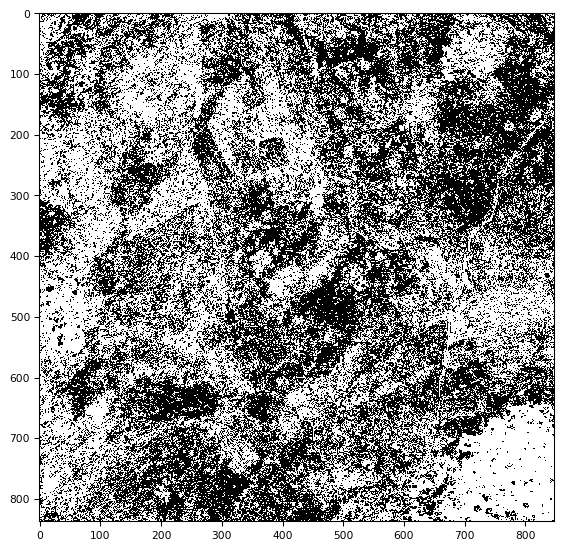

In [17]:
def show_mask(m):
    # hack for nice display
    tiff.imshow(255 * np.stack([m, m, m]));
show_mask(pred_binary_mask[:,:])
print POLY_TYPE, IM_ID